# 7장 물류네트워크 최적설계를 위한 테크닉 10

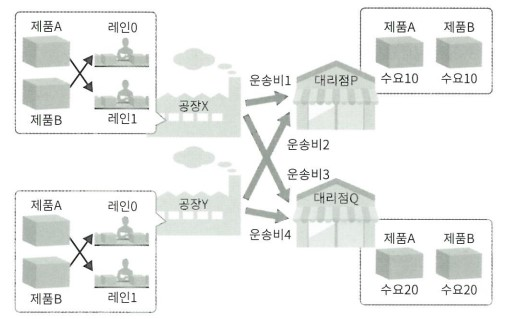

< 전제조건 >
- 대리점의 판매 수요를 근거로 -> 공장의 생산량 결정
- 각각 제품을 어느 공장의 어느 생산라인(0/1)에서 제조할지 -> 공장~대리점 간의 운송비, 제고 비용 등 고려

In [1]:
# 경고(warning) 비표시
import warnings
warnings.filterwarnings('ignore')

## 61. 운송 최적화 문제를 풀어보자

< 라이브러리 소개 >
- pulp: 최적화 모델 작성
    - LpVariable: 변수를 정의하는 객체
```
 LpVariable('변수이름', lowBound=하한, upBound=상한, cat=범주)
```
    - IpSum: 리스트나 반복 가능한 객체의 합을 계산할 때 사용하는 함수, 목표 함수나 제약 조건을 만들 때 자주 사용된다
```
lpSum(리스트 또는 반복 가능한 객체)
```
    - solve: 최적해를 구하는 함수, 정의된 목표 함수과 제약 조건을 기반으로 최소화 모델을 푼다
```
model.solve()
```


- ortoolpy: 목적함수를 생성해서 최적화 문제를 푸는 역할
    - model_min: 최소화 모델 생성 함수
```
model.model_min()
```
    - model_max: 최대화 모델 생성 함수
```
model.model_max()
```



In [2]:
# 0. 라이브러리 설치
!pip install pulp
!pip install ortoolpy

In [3]:
# 1. 라이브러리 임포트
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals

# 2. 데이터 불러오기
df_tc = pd.read_csv('trans_cost.csv', index_col="공장")   # df_tc: 운송비용
df_demand = pd.read_csv('demand.csv')                     # df_demand: 대리점 수요량
df_supply = pd.read_csv('supply.csv')                     # df_supply: 공장 공급량

# 3. 초기 설정
np.random.seed(1)
nw = len(df_tc.index)                         # nw(df_tc의 행): 공장(W1~W3)
nf = len(df_tc.columns)                       # nf(df_tc의 열): 대리점(F1~F4)
pr = list(product(range(nw), range(nf)))      # pr: 공장-대리점 리스트

# 4. 모델 작성
m1 = model_min()        # 최소화 모델 m1 정의
v1 = {(i,j):LpVariable('v%d_%d'%(i,j),lowBound=0) for i,j in pr}    # 공장-대리점 운송량 변수 v1 (>=0)

## 목적 함수: 운송 비용 최소화
m1 += lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr)

## 제약 조건 추가
for i in range(nw):
    m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i]   # 공급량 초과X 제약
for j in range(nf):
    m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][j]   # 수요량 충족 제약
m1.solve()

# 5. 총 운송 비용 계산
df_tr_sol = df_tc.copy()
total_cost = 0
## v1.items() -> i에서 j로 보내는 운송량 k: (i, j) & 최적화 결과 x
for k,x in v1.items():
    i,j = k[0],k[1]
    df_tr_sol.iloc[i][j] = value(x)
    total_cost += df_tc.iloc[i][j]*value(x)   # 총 운송 비용 = sum(각 운송비용 * 최적 운송량)

print(df_tr_sol)
print("총 운송 비용:"+str(total_cost))

    F1  F2  F3  F4
공장                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
총 운송 비용:1296.0


- 기존 총 운송 비용: 1433만원
- 최적화 계산 결과, 총 운송 비용: 1296만원

## 62. 최적 운송 경로를 네트워크로 확인하자

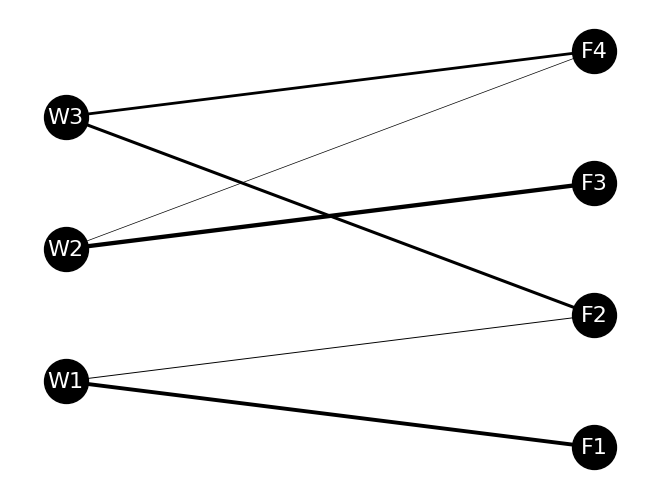

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# 데이터 불러오기
df_tr = df_tr_sol.copy()                        # df_tr: 최적 운송량
df_pos = pd.read_csv('trans_route_pos.csv')     # df_pos: 노드 좌표

# 객체 생성
G = nx.Graph()

# 노드 설정
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

# 엣지 설정 & 엣지의 가중치 리스트화
num_pre = 0
edge_weights = []             # edge_weights: 엣지의 굵기를 나타내는 가중치 리스트
size = 0.1                    # size: 가중치 조정

for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i==j):
            # 엣지 추가
            G.add_edge(df_pos.columns[i],df_pos.columns[j])
            # 엣지 가중치 추가
            if num_pre<len(G.edges):
                num_pre = len(G.edges)
                weight = 0

                # 운송량이 존재하는지 확인 -> 가중치 설정(weight = 운송량 * size)
                if (df_pos.columns[i] in df_tr.columns)and(df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
                elif(df_pos.columns[j] in df_tr.columns)and(df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
                edge_weights.append(weight)


# 좌표 설정
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0],df_pos[node][1])

# 그리기
nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, node_color='k', font_color='w', width=edge_weights)

# 표시
plt.show()



> "운송 경로는 어느 정도 집중돼야 한다."



## 63. 최적 운송 경로가 제약 조건을 만족하는지 확인하자

In [5]:
import pandas as pd
import numpy as np

# 데이터 불러오기
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

# 제약조건 계산함수
#
# 수요측 condition_demand
# df_tr: 최적 운송량, df_demand: 대리점 수요량
# 총 운송량 >= 대리점 요구량  :flag = 1
def condition_demand(df_tr,df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum>=df_demand.iloc[0][i]):
            flag[i] = 1
    return flag

# 공급측 condition_supply
# 총 운송량 <= 공장 공급량  :flag = 1
def condition_supply(df_tr,df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum<=df_supply.iloc[0][i]:
            flag[i] = 1
    return flag

print("수요 조건 계산 결과:"+str(condition_demand(df_tr_sol,df_demand)))
print("공급 조건 계산 결과:"+str(condition_supply(df_tr_sol,df_supply)))

수요 조건 계산 결과:[1. 1. 1. 1.]
공급 조건 계산 결과:[1. 1. 1.]


- 수요와 공급 조건 모두 충족되고 있다.

## 64. 생산 계획 데이터를 불러오자

- product_plan_material.csv: 제품 제조에 필요한 원료 비율
- product_plan_profit.csv: 제품 이익
- product_plan_stock.csv: 원료 재고
- product_plan.csv: 제품 생산량

In [6]:
import pandas as pd

df_material = pd.read_csv('product_plan_material.csv', index_col="제품")    # df_material: 원료 비율
print(df_material)
df_profit = pd.read_csv('product_plan_profit.csv', index_col="제품")        # df_profit: 제품 이익
print(df_profit)
df_stock = pd.read_csv('product_plan_stock.csv', index_col="항목")          # df_stock: 원료 재고
print(df_stock)
df_plan = pd.read_csv('product_plan.csv', index_col="제품")                 # df_plan: 제품 생산량
print(df_plan)

     원료1  원료2  원료3
제품                
제품1    1    4    3
제품2    2    4    1
      이익
제품      
제품1  5.0
제품2  4.0
    원료1  원료2  원료3
항목               
재고   40   80   50
      생산량
제품       
제품1    16
제품2     0


## 65. 이익을 계산하는 함수를 만들자

< 생산계획 최적화 >
1.   목적함수, 제약조건 정의
      - 목적함수: 이익함수 최대화
      - 제약조건: 각 원료의 사용량 <= 재고
2.   제약조건 내에서 목적함수를 최적화하는 변수 찾기





> 생산계획의 총 이익 = sum(각 제품의 이익 X 제조량)




In [7]:
# 이익 계산 함수
def product_plan(df_profit,df_plan):
    profit = 0
    for i in range(len(df_profit.index)):
        for j in range(len(df_plan.columns)):
            profit += df_profit.iloc[i][j]*df_plan.iloc[i][j]
    return profit

print("총 이익:"+str(product_plan(df_profit,df_plan)))

총 이익:80.0


## 66. 생산 최적화 문제를 풀어보자

In [8]:
# 1. 라이브러리 임포트
import pandas as pd
from pulp import LpVariable, lpSum, value
from ortoolpy import model_max, addvars, addvals

# 2. 데이터 불러오기
df = df_material.copy()
inv = df_stock

# 3. 모델 작성
m = model_max()     # 최대화 모델 m 정의
v1 = {(i):LpVariable('v%d'%(i),lowBound=0) for i in range(len(df_profit))}

## 목적 함수: 이익 최대화 <- sum(변수 v1 * 제품별 이익의 곱)
m += lpSum(df_profit.iloc[i]*v1[i] for i in range(len(df_profit)))

## 제약 조건 추가: 각 원료의 사용량 <= 재고
for i in range(len(df_material.columns)):
    m += lpSum(df_material.iloc[j,i]*v1[j] for j in range(len(df_profit)) ) <= df_stock.iloc[:,i]
m.solve()

# 4. 총 이익 계산
df_plan_sol = df_plan.copy()
for k,x in v1.items():
    df_plan_sol.iloc[k] = value(x)
print(df_plan_sol)
print("총 이익:"+str(value(m.objective)))

      생산량
제품       
제품1    15
제품2     5
총 이익:95.0


< 최적화 결과 >


1.   제품1의 생산량: 16 -> 15
2.   제품2의 생산량: 0 -> 5
3.   총 이익: 80 -> 95



## 67. 최적 생산 계획이 제약 조건을 만족하는지 확인하자

In [9]:
# 제약 조건 계산 함수 condition_stock
# 각 원료의 사용량 <= 재고  :flag = 1
def condition_stock(df_plan,df_material,df_stock):
    flag = np.zeros(len(df_material.columns))
    for i in range(len(df_material.columns)):
        temp_sum = 0
        for j in range(len(df_material.index)):
            temp_sum = temp_sum + df_material.iloc[j][i]*float(df_plan.iloc[j])
        if (temp_sum<=float(df_stock.iloc[0][i])):
            flag[i] = 1
        print(df_material.columns[i]+"  사용량:"+str(temp_sum)+", 재고:"+str(float(df_stock.iloc[0][i])))
    return flag

print("제약 조건 계산 결과:"+str(condition_stock(df_plan_sol,df_material,df_stock)))

원료1  사용량:25.0, 재고:40.0
원료2  사용량:80.0, 재고:80.0
원료3  사용량:50.0, 재고:50.0
제약 조건 계산 결과:[1. 1. 1.]


- 제약 조건은 모두 충족됐다.
- 원료2와 원료3은 재고를 모두 사용하고 원료1은 조금 남아있지만 원료의 사용 효율이 크게 개선되었다.

## 68. 물류 네트워크 설계 문제를 풀어보자

< 물류 네트워크 설계 문제 >
  - 운송 경로 + 생산 계획 최적화 문제
  - 상품의 수요가 결정되어 있으면, 수요를 만족하면서, 운송 비용과 제조 비용이 최소가 되도록 설계한다

  1. 목적 함수: 운송 비용 + 제조 비용
  2. 제약 조건: 각 대리점의 판매 수 >= 수요수

- ortoolpy 라이브러리
  - logistics_network: 최적 설계 함수



```
# 1. 세 개의 변수를 반환하지만 두 번째 변수만 저장 (최적화 결과)
# 2. 테이블 tbde, tbdi, tbfa 사용하여 최적화
# 3. 나머지: 지정된 열

from ortoolpy import logistics_network
_, tbdi2, _ = logistics_network(tbde, tbdi, tbfa,dep = "대리점", dem = "수요",fac = "공장",
                                prd = "제품",tcs = "운송비",pcs = "생산비",lwb = "하한",upb = "상한")
```

In [10]:
import numpy as np
import pandas as pd

제품 = list('AB')
대리점 = list('PQ')
공장 = list('XY')
레인 = (2,2)

# 운송비
tbdi = pd.DataFrame(((j,k) for j in 대리점 for k in 공장), columns=['대리점','공장'])
tbdi['운송비'] = [1,2,3,1]
print(tbdi)

# 수요
tbde = pd.DataFrame(((j,i) for j in 대리점 for i in 제품), columns=['대리점','제품'])
tbde['수요'] = [10,10,20,20]
print(tbde)

# 생산
tbfa = pd.DataFrame(((k,l,i,0,np.inf) for k,nl in zip (공장,레인) for l in range(nl) for i in 제품),
                    columns=['공장','레인','제품','하한','상한'])
tbfa['생산비'] = [1,np.nan,np.nan,1,3,np.nan,5,3]
tbfa.dropna(inplace=True)
tbfa.loc[4,'상한']=10
print(tbfa)

from ortoolpy import logistics_network
_, tbdi2, _ = logistics_network(tbde, tbdi, tbfa,dep = "대리점", dem = "수요",fac = "공장",
                                prd = "제품",tcs = "운송비",pcs = "생산비",lwb = "하한",upb = "상한")

print(tbfa)       # 최적 생산량
print(tbdi2)      # 최적 운송량

  대리점 공장  운송비
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1
  대리점 제품  수요
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20
  공장  레인 제품  하한    상한  생산비
0  X   0  A   0   inf  1.0
3  X   1  B   0   inf  1.0
4  Y   0  A   0  10.0  3.0
6  Y   1  A   0   inf  5.0
7  Y   1  B   0   inf  3.0
  공장  레인 제품  하한    상한  생산비     VarY  ValY
0  X   0  A   0   inf  1.0  v000009  20.0
3  X   1  B   0   inf  1.0  v000010  10.0
4  Y   0  A   0  10.0  3.0  v000011  10.0
6  Y   1  A   0   inf  5.0  v000012   0.0
7  Y   1  B   0   inf  3.0  v000013  20.0
  대리점 공장  운송비 제품     VarX  ValX
0   P  X    1  A  v000001  10.0
1   P  X    1  B  v000002  10.0
2   Q  X    3  A  v000003  10.0
3   Q  X    3  B  v000004   0.0
4   P  Y    2  A  v000005   0.0
5   P  Y    2  B  v000006   0.0
6   Q  Y    1  A  v000007  10.0
7   Q  Y    1  B  v000008  20.0


- tbfa의 ValY: 최적 생산량
- tbdi2의 ValX: 최적 운송량

## 69. 최적 네트워크의 운송 비용과 그 내역을 계산하자

운송비용 = '운송비' * 'ValX'

In [11]:
tbdi2 = tbdi2[["공장","대리점","운송비","제품","VarX","ValX"]]
tbdi2

,공장,대리점,운송비,제품,VarX,ValX
0,X,P,1,A,v000001,10.0
1,X,P,1,B,v000002,10.0
2,X,Q,3,A,v000003,10.0
3,X,Q,3,B,v000004,0.0
4,Y,P,2,A,v000005,0.0
5,Y,P,2,B,v000006,0.0
6,Y,Q,1,A,v000007,10.0
7,Y,Q,1,B,v000008,20.0


In [14]:
trans_cost = 0
for i in range(len(tbdi2.index)):
    trans_cost += tbdi2["운송비"].iloc[i]*tbdi2["ValX"].iloc[i]
print("총 운송비:"+str(trans_cost))

총 운송비:80.0


< 최적의 운송 >
- 운송비가 적은 X -> P, Y -> Q 경로를 사용하자
- Q에 대한 상품 A의 수요가 약간 부족하기 때문에 X -> Q로 A를 10만큼 운송

## 70. 최적 네트워크의 생산 비용과 그 내역을 계산하자

생산비용 = '생산비' * 'ValY'

In [12]:
tbfa

,공장,레인,제품,하한,상한,생산비,VarY,ValY
0,X,0,A,0,inf,1.0,v000009,20.0
3,X,1,B,0,inf,1.0,v000010,10.0
4,Y,0,A,0,10.0,3.0,v000011,10.0
6,Y,1,A,0,inf,5.0,v000012,0.0
7,Y,1,B,0,inf,3.0,v000013,20.0


In [13]:
product_cost = 0
for i in range(len(tbfa.index)):
    product_cost += tbfa["생산비"].iloc[i]*tbfa["ValY"].iloc[i]
print("총 생산비:"+str(product_cost))

총 생산비:120.0


< 최적의 운송 >
- 생산 비용이 낮은 공장 X에서 생산량을 늘린다
  - X에서 A의 생산량 = 20, B의 생산량 = 10
- 운송 비용까지 고려하면 수요량이 많은 대리점 Q까지의 운송비용이 적은 공장 Y에서의 생산량도 늘려야 한다
  - Y에서 A의 생산량 = 10, B의 생산량 = 20